[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Harvard-CS1090/2026_CS1090B_public/blob/main/sec04/cs1090b_sec04_solutions.ipynb)

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">

# CS1090B Section 4: CNNs, Data Pipelines, and Transfer Learning

**Harvard University**<br/>
**Spring 2026**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb<br/>

## Overview

In this section, we explore Convolutional Neural Networks (CNNs), PyTorch data pipelines, and transfer learning.

- **Part 1** reviews the building blocks of a CNN — convolutional layers, pooling, flatten, dense, dropout, and global average pooling — and builds a LeNet-style architecture from scratch.
- **Part 2** applies CNNs to classify the Kannada-MNIST dataset. We compare a fully-connected baseline against a CNN, then use the CNN as a feature extractor for a Random Forest classifier.
- **Part 3** introduces PyTorch data pipelines: `Dataset`, `DataLoader`, transforms, data augmentation, and train/validation splitting using the Horses-or-Humans dataset.
- **Part 4** demonstrates transfer learning with a pretrained MobileNetV2 to classify horses vs. humans with minimal training.

## Learning Objectives

By the end of this section, you should be able to:

### Conceptual Understanding
1. Explain why CNNs are better suited for image data than fully-connected networks (spatial structure, weight sharing, local receptive fields).
2. Describe the role of each CNN building block — convolution, pooling, flatten, dense, dropout, and global average pooling.
3. Explain how a trained CNN can serve as a feature extractor for classical ML models.
4. Articulate why transfer learning works: what general features pretrained models learn and how they transfer to new tasks.
5. Distinguish between preprocessing transforms (deterministic, applied everywhere) and augmentation transforms (stochastic, training only).

### Practical Skills (PyTorch)
6. Build a CNN architecture from scratch using `nn.Module` and calculate feature map dimensions through the network.
7. Train and evaluate binary classifiers using `BCEWithLogitsLoss` with early stopping.
8. Use `torchvision.datasets.ImageFolder` to load image datasets organized by class directories.
9. Construct PyTorch data pipelines with `Dataset`, `DataLoader`, and `transforms.Compose`.
10. Apply data augmentation (flips, rotations, color jitter) to training data using torchvision transforms.
11. Perform transfer learning: load a pretrained model, freeze the backbone, and train a new classifier head.

## Setup: Download Data

In [1]:
# Environment detection and setup
import os
import subprocess
import sys
import shutil
import zipfile
import urllib.request

# --- 1. Download notebook_assets.zip (kmnist data, CNN features, figures) ---
assets_zip_url = "https://github.com/Harvard-CS1090/2026_CS1090B_public/raw/main/sec04/notebook_assets.zip"
assets_zip_name = "notebook_assets.zip"
expected_dirs = ["data", "fig"]

all_dirs_exist = all(os.path.isdir(d) for d in expected_dirs)

if all_dirs_exist:
    print("Required directories already exist. Skipping asset download.")
else:
    print(f"Downloading {assets_zip_name} from GitHub...")
    try:
        if 'google.colab' in sys.modules:
            subprocess.run(['wget', '-q', assets_zip_url], check=True)
        else:
            urllib.request.urlretrieve(assets_zip_url, assets_zip_name)
        with zipfile.ZipFile(assets_zip_name, "r") as zip_ref:
            zip_ref.extractall(".")
        os.remove(assets_zip_name)
        if os.path.isdir('__MACOSX'):
            shutil.rmtree('__MACOSX')
        print("Asset download complete.")
    except Exception as e:
        print(f"Error during asset setup: {e}", file=sys.stderr)

# --- 2. Download Horses-or-Humans images (for Parts 3 & 4) ---
hoh_dir = "data/horses_or_humans"
if os.path.isdir(hoh_dir):
    print("Horses-or-Humans data already exists. Skipping download.")
else:
    os.makedirs(hoh_dir, exist_ok=True)
    base_url = "https://storage.googleapis.com/learning-datasets"
    for split, fname in [("train", "horse-or-human.zip"), ("test", "validation-horse-or-human.zip")]:
        url = f"{base_url}/{fname}"
        dest_zip = os.path.join(hoh_dir, fname)
        dest_dir = os.path.join(hoh_dir, split)
        print(f"Downloading {fname}...")
        urllib.request.urlretrieve(url, dest_zip)
        with zipfile.ZipFile(dest_zip, "r") as zf:
            zf.extractall(dest_dir)
        os.remove(dest_zip)
    print("Horses-or-Humans download complete.")

print("Setup complete!")

Required directories already exist. Skipping asset download.
Horses-or-Humans data already exists. Skipping download.
Setup complete!


## Part 1: CNN Building Blocks

![CNN Architecture](fig/cnn1.png)

The following is a review of the core layers used when building CNNs with PyTorch.
A link to the official PyTorch documentation for each layer is provided.

In [2]:
import copy
import os
import random as rn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split, Subset
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Device setup
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, using CUDA.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, using MPS.")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU.")


# Reproducibility
os.environ['PYTHONHASHSEED'] = '0'
SEED = 109
np.random.seed(SEED)
rn.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

MPS device found, using MPS.


### 2D Convolutional Layers

[**torch.nn.Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)`(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True)`

![Convolutional Filters](fig/conv-many-filters.png)

**Quick review:**

A convolutional layer is composed of **filters**, which are composed of **kernels** which are themselves composed of **weights**. Each filter also has a bias term (often omitted in diagrams). We learn the weights and biases from our data. Each conv layer also has an associated **activation function** such as ReLU or sigmoid.

The **number of filters** and the **height and width of the kernels** are set by the `out_channels` and `kernel_size` arguments respectively.

The **depth of the filters is fixed** by the depth (i.e., `in_channels`) of the input to the conv layer.

The output of the conv layer is a 3D tensor — a set of **feature maps**. Each feature map is the output of one filter convolving on the input. The height and width of the output is determined by the input size, `kernel_size`, `padding`, and `stride`. The depth of the output tensor (number of feature maps) equals the number of filters.

**Important:** PyTorch uses **NCHW** format (batch, channels, height, width) by default.

PyTorch also has [1D convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) for time series and [3D convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html) for video.

### Pooling Layers

[**torch.nn.MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)`(kernel_size, stride=None, padding=0)`

![MaxPool](fig/maxpool.png)

Pooling layers reduce spatial dimensions. A `MaxPool2d` with a 2×2 kernel and stride 2 outputs feature maps that are half the size of the input. For each 2×2 region, only the maximum value is kept.

When `stride` is not specified, it defaults to `kernel_size`.

### Flatten Layers

[**torch.nn.Flatten**](https://docs.pytorch.org/docs/stable/generated/torch.flatten.html)`(start_dim=1)`

`Flatten` has no learned parameters. It reshapes the multi-dimensional feature maps into a flat vector. It sits between the final convolutional/pooling output and the first fully connected layer. The default `start_dim=1` preserves the batch dimension.

### Fully Connected Layers

[**torch.nn.Linear**](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)`(in_features, out_features, bias=True)`

![Dense Layer](fig/dense.png)

Most CNNs have one or more fully connected (linear) layers at the end, with the final layer referred to as the **output layer**. You specify `in_features` and `out_features` (the number of neurons).

PyTorch's `nn.Linear` does **not** include an activation function — you apply activations separately (e.g., `nn.ReLU()` as the next layer).

*The choice of activation for the output layer depends on the task:* linear for regression, sigmoid for binary classification, softmax (or no activation with `CrossEntropyLoss`) for multi-class.

### Dropout Layers

[**torch.nn.Dropout**](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)`(p=0.5)`

![Dropout](fig/dropout.gif)
                                     
Dropout randomly sets a fraction p of input units to 0 during training, and scales the remaining activations by $1/(1-p)$ to maintain the expected output magnitude. At evaluation time, all units are active and no scaling is applied. Dropout helps prevent overfitting by limiting the model's ability to co-adapt neurons.  

**Caution:** Dropout's behavior differs when applied after convolutional vs. dense layers! Standard `nn.Dropout` drops individual values; for conv layers, `nn.Dropout2d` drops entire channels.

**Important:** In PyTorch, you must call `model.train()` before training and `model.eval()` before evaluation to toggle dropout (and batch norm) behavior.

### Global Average Pooling

[**torch.nn.AdaptiveAvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)`(output_size)`

Global Average Pooling (GAP) calculates the average value of each feature map, reducing the spatial dimensions to 1×1. If a convolutional layer outputs feature maps of shape `(C, H, W)`, applying `AdaptiveAvgPool2d(1)` reduces this to `(C, 1, 1)`, which can be squeezed to a flat vector of length `C`.

**Why use GAP?**

- **Reduces overfitting:** Summarizing spatial information reduces total parameters compared to using `Flatten` + `Linear` directly after conv layers.
- **Seamless transition to classification:** The output is a flat vector of length equal to the number of feature maps, which can be fed directly into a classifier.

> **❓ Question 1: CNN Layer Concepts**
>
> 1. What determines the depth (number of channels) of a convolutional layer's output?
> 2. Why might it make sense to think of dropout as a type of ensemble method?
> 3. What is the advantage of Global Average Pooling over Flatten before the classifier?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. The depth of a convolutional layer's output equals the **number of filters** (`out_channels`). Each filter produces one feature map, so if you have 64 filters, the output has 64 channels.
>
> 2. With dropout, each forward pass uses a random subset of neurons — effectively a different "thinned" subnetwork. The final model approximates an average over all possible subnetworks, similar to how an ensemble averages predictions from multiple models. This prevents any single neuron from becoming a bottleneck.
>
> 3. `Flatten` preserves all spatial values, creating a very large vector (e.g., 7×7×512 = 25,088 values) that requires a correspondingly large `Linear` layer with many parameters. GAP reduces each feature map to a single number regardless of spatial size, so the vector length equals only the number of channels (e.g., 512). This dramatically reduces parameters and overfitting risk, and makes the model more robust to input spatial variations.

</details>

### Exercise: Building LeNet from Scratch

Now let's build a CNN model with a similar architecture to [**LeNet**](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) from scratch using `nn.Module`.

The architecture:
- **Input:** 32×32 grayscale images (1 channel)
- **Conv1:** 6 filters, kernel 5×5, stride 1, no padding → ReLU
- **Pool1:** MaxPool 2×2, stride 2
- **Conv2:** 16 filters, kernel 5×5, stride 1, no padding → ReLU
- **Pool2:** MaxPool 2×2, stride 2
- **Conv3:** 120 filters, kernel 5×5 → ReLU
- **Flatten**
- **FC1:** 84 units → ReLU
- **Output:** 10 units (raw logits — use with `CrossEntropyLoss`)

In [3]:
# Build a LeNet model from scratch using nn.Module
# your code here
# BEGIN SOLUTION

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution Layer 1: 6 filters of size 5x5, stride=1, no padding
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # Pooling Layer 1: Max Pooling with pool size 2x2, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolution Layer 2: 16 filters of size 5x5, stride=1, no padding
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # Convolution Layer 3: 120 filters of size 5x5
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        # Fully Connected Layer: 84 units
        self.fc1 = nn.Linear(120, 84)
        # Output Layer: 10-class classification
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (N,1,32,32) -> (N,6,14,14)
        x = self.pool(F.relu(self.conv2(x)))    # -> (N,16,5,5)
        x = F.relu(self.conv3(x))               # -> (N,120,1,1)
        x = x.flatten(1)                        # -> (N,120)
        x = F.relu(self.fc1(x))                 # -> (N,84)
        x = self.fc2(x)                         # -> (N,10)
        return x

lenet = LeNet()
print(lenet)

# Verify with a dummy input
dummy = torch.randn(1, 1, 32, 32)
print(f"\nOutput shape: {lenet(dummy).shape}")
# END SOLUTION

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

Output shape: torch.Size([1, 10])


In [4]:
def model_summary(model, input_size):
    """Print layer-by-layer output shapes and parameter counts."""
    headers = f"{'Layer':<35} {'Output Shape':<20} {'Params':>10}"
    print(headers)
    print("=" * len(headers))

    total_params = 0
    def hook_fn(name):
        def hook(module, input, output):
            nonlocal total_params
            params = sum(p.numel() for p in module.parameters(recurse=False))
            total_params += params
            shape = list(output.shape)
            print(f"{name:<35} {str(shape):<20} {params:>10,}")
        return hook

    hooks = []
    for name, layer in model.named_modules():
        if not name or list(layer.children()):  # skip root and container modules
            continue
        hooks.append(layer.register_forward_hook(hook_fn(name)))

    with torch.no_grad():
        model(torch.randn(*input_size))

    for h in hooks:
        h.remove()
    print("=" * len(headers))
    print(f"{'Total':<55} {total_params:>10,}")


model_summary(lenet, (1, 1, 32, 32))

Layer                               Output Shape             Params
conv1                               [1, 6, 28, 28]              156
pool                                [1, 6, 14, 14]                0
conv2                               [1, 16, 10, 10]           2,416
pool                                [1, 16, 5, 5]                 0
conv3                               [1, 120, 1, 1]           48,120
fc1                                 [1, 84]                  10,164
fc2                                 [1, 10]                     850
Total                                                       61,706


> **❓ Question 2: LeNet Architecture**
>
> 1. After Conv1 (kernel 5×5, no padding) and Pool1 (2×2), what is the spatial size of the feature maps? Start from 32×32 input.
> 2. Why does Conv3 have output spatial size 1×1?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Conv1 with kernel 5 and no padding: output = 32 - 5 + 1 = **28×28**. Then Pool1 with kernel 2, stride 2: output = 28/2 = **14×14**.
>
> 2. After Conv2 + Pool2, the spatial size is 5×5 (Conv2: 14-5+1=10, Pool2: 10/2=5). Conv3 has kernel size 5 with no padding, so the output is 5-5+1 = **1×1**. The kernel is exactly the size of the input feature map, so Conv3 effectively acts as a fully-connected layer over the spatial dimensions.

</details>

## Part 2: CNN Classification with KMNIST

Now that we understand the building blocks — convolutional layers, pooling, flatten, dense, dropout, and GAP — let's put them to work on a real classification task. We'll see how a CNN compares to a fully-connected network, and explore a powerful idea: using the CNN's learned features as input to a classical ML model.

### The Kannada MNIST Dataset

![Kannada MNIST](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)

For this part, we will work with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in a Dravidian language spoken in southern India.

This dataset consists of 60,000 28×28 grayscale images of ten digits, along with a test set of 10,000 images. For this section, we simplify the problem by using only the digits labeled `0` and `1` (which are visually similar), with 1,200 training samples and 2,000 test samples.

To understand the dataset better, see this [article](https://medium.com/data-science/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the dataset curator.

In [5]:
# Load KMNIST data from CSV files

df_train = pd.read_csv("data/kmnist_train.csv")
X_kmnist_train = df_train.drop(columns="output").values
y_kmnist_train = df_train["output"].values

df_test = pd.read_csv("data/kmnist_test.csv")
X_kmnist_test = df_test.drop(columns="output").values
y_kmnist_test = df_test["output"].values

# Reshape to NCHW format and normalize to [0, 1]
X_kmnist_train = X_kmnist_train.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
X_kmnist_test = X_kmnist_test.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

print(
    "The shapes of the Kannada MNIST X and y datasets are:\n\n"
    f"\tX train\t{X_kmnist_train.shape}\n\ty train\t{y_kmnist_train.shape}\n"
    f"\n\tX test\t{X_kmnist_test.shape}\n\ty test\t{y_kmnist_test.shape}"
)

The shapes of the Kannada MNIST X and y datasets are:

	X train	(1200, 1, 28, 28)
	y train	(1200,)

	X test	(2000, 1, 28, 28)
	y test	(2000,)


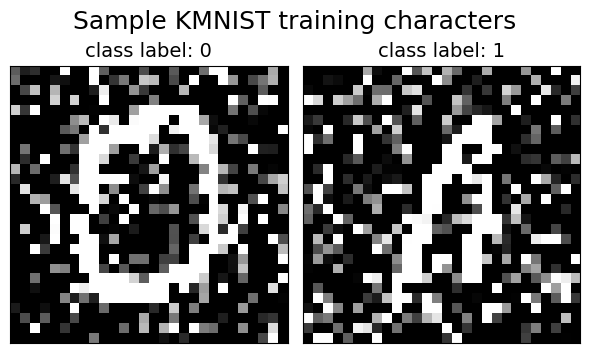

In [6]:
# Visualize sample KMNIST training characters
idx_list = [2, 1]
fig, axes = plt.subplots(1, 2, figsize=(6, 3.5))

plt.suptitle("Sample KMNIST training characters", y=1, fontsize=18)

for idx, ax in zip(idx_list, axes.flat):
    ax.imshow(X_kmnist_train[idx, 0], cmap="gray")  # index channel dim for imshow
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"class label: {y_kmnist_train[idx]}", fontsize=14)

plt.tight_layout()

### Preparing Data for PyTorch

We convert our NumPy arrays to PyTorch tensors, create `TensorDataset` objects, and wrap them in `DataLoader`s for batched training. We also split 20% of the training set for validation.

In [7]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_kmnist_train, dtype=torch.float32)
y_train_t = torch.tensor(y_kmnist_train, dtype=torch.float32)
X_test_t = torch.tensor(X_kmnist_test, dtype=torch.float32)
y_test_t = torch.tensor(y_kmnist_test, dtype=torch.float32)

# Train/validation split (80/20)
n_val = int(0.2 * len(X_train_t))
n_train = len(X_train_t) - n_val
generator = torch.Generator().manual_seed(SEED)

full_ds = TensorDataset(X_train_t, y_train_t)
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=generator)
test_ds = TensorDataset(X_test_t, y_test_t)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {n_train}, Val: {n_val}, Test: {len(X_test_t)}")

Train: 960, Val: 240, Test: 2000


### Training Utilities

We define reusable training, evaluation, and plotting functions for binary classification with `BCEWithLogitsLoss`.

In [8]:
class EarlyStopping:
    """Early stopping to halt training when validation loss stops improving."""
    def __init__(self, patience=10, min_delta=0.0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_loss = np.inf
        self.best_state = None
        self.counter = 0

    def step(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best:
                self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)


def train_binary(model, train_loader, val_loader, optimizer, epochs=100,
                 early_stopping=None):
    """Train a binary classifier with BCEWithLogitsLoss."""
    criterion = nn.BCEWithLogitsLoss()
    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb).squeeze(1)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            correct += ((torch.sigmoid(logits) > 0.5).float() == yb).sum().item()
            total += yb.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb).squeeze(1)
                loss = criterion(logits, yb)
                val_loss_sum += loss.item() * xb.size(0)
                val_correct += ((torch.sigmoid(logits) > 0.5).float() == yb).sum().item()
                val_total += yb.size(0)

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        history["loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        if early_stopping and early_stopping.step(val_loss, model):
            break

    if early_stopping:
        early_stopping.restore(model)

    return history


def evaluate_binary(model, loader):
    """Evaluate a binary classifier; returns (loss, accuracy)."""
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb).squeeze(1)
            loss_sum += criterion(logits, yb).item() * xb.size(0)
            correct += ((torch.sigmoid(logits) > 0.5).float() == yb).sum().item()
            total += yb.size(0)
    return loss_sum / total, correct / total


def plot_hist(history, title=None):
    """Plot training history (loss and accuracy)."""
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(history["loss"], label="train")
    axs[0].plot(history["val_loss"], label="val")
    best_epoch = np.argmin(history["val_loss"])
    axs[0].axvline(best_epoch, c="k", ls=":", label="best val epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("BCE Loss")
    axs[0].legend()

    axs[1].plot(history["accuracy"], label="train")
    axs[1].plot(history["val_accuracy"], label="val")
    axs[1].axvline(best_epoch, c="k", ls=":", label="best val epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    if title:
        plt.suptitle(title)
    plt.tight_layout()


def print_test_results(model_name, test_results):
    loss, acc = test_results
    print(f"{model_name} performance on test set:\n"
          f"\tTest Loss: {loss:.4f}\n\tTest Accuracy: {acc:.4f}")

### Fully-Connected Network (Baseline)

First, let's build a fully-connected network similar to what we've seen before. The input images are flattened to 784-dimensional vectors. We use L2 regularization via `weight_decay` in the optimizer.

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=100, out_features=100, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.1, inplace=False)
  (10): Linear(in_features=100, out_features=1, bias=True)
)


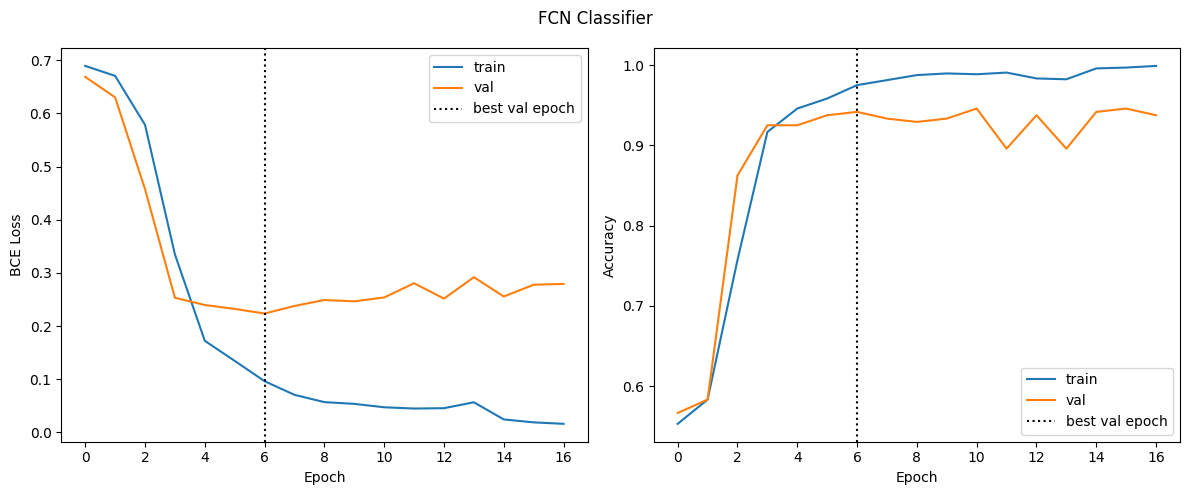

In [9]:
# Fully-connected network with regularization
torch.manual_seed(SEED)
fcn_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 1),
).to(device)

print(fcn_model)

# Use weight_decay for L2 regularization 
optimizer = optim.Adam(fcn_model.parameters(), lr=0.001, weight_decay=0.003)
early_stop = EarlyStopping(patience=10, restore_best=True)

torch.manual_seed(SEED)
history_fcn = train_binary(fcn_model, train_loader, val_loader, optimizer,
                           epochs=100, early_stopping=early_stop)

plot_hist(history_fcn, "FCN Classifier")

In [10]:
print_test_results("Fully-connected network", evaluate_binary(fcn_model, test_loader))

Fully-connected network performance on test set:
	Test Loss: 0.1785
	Test Accuracy: 0.9265


### Baseline CNN Classifier

Now let's build a CNN that takes advantage of the spatial structure in the image data. We use three convolutional blocks (Conv → ReLU → MaxPool), followed by a flattened dense layer and a single logit output (used with `BCEWithLogitsLoss`).

In [11]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> 14x14
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> 7x7
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # -> 7x7
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> 3x3
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 3 * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


torch.manual_seed(SEED)
baseline_cnn = BaselineCNN().to(device)
print(baseline_cnn)
print(f"\nTotal parameters: {sum(p.numel() for p in baseline_cnn.parameters()):,}")

BaselineCNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=144, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 33,073


💬 **Discuss:** Notice that `BaselineCNN` separates the network into `self.features` (conv blocks) and `self.classifier` (dense layers). Why might this separation be useful beyond just code organization?

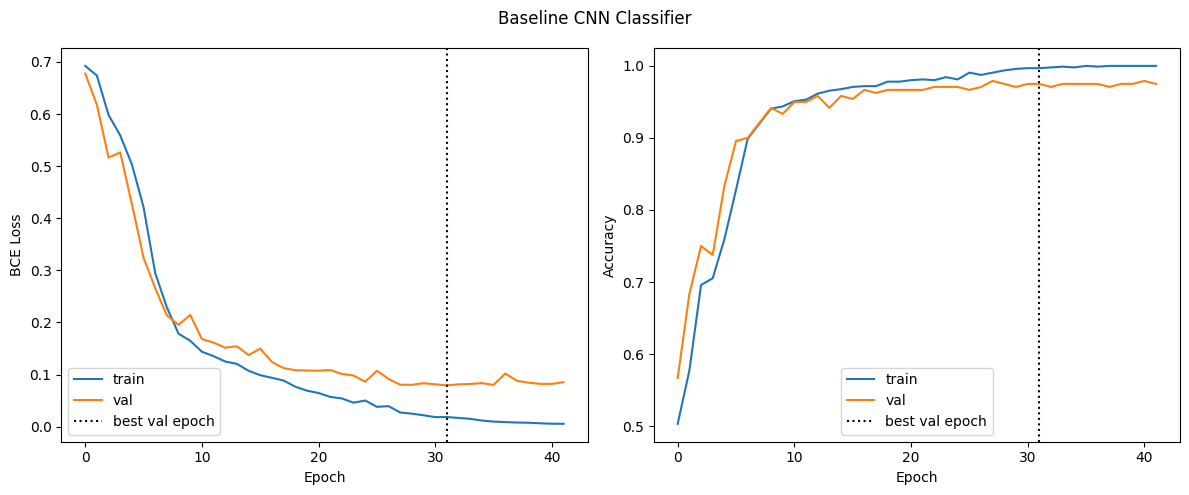

In [12]:
optimizer = optim.Adam(baseline_cnn.parameters(), lr=0.001)
early_stop = EarlyStopping(patience=10, restore_best=True)

torch.manual_seed(SEED)
history_cnn = train_binary(baseline_cnn, train_loader, val_loader, optimizer,
                           epochs=50, early_stopping=early_stop)

plot_hist(history_cnn, "Baseline CNN Classifier")

In [13]:
print_test_results("Baseline CNN model", evaluate_binary(baseline_cnn, test_loader))

Baseline CNN model performance on test set:
	Test Loss: 0.1536
	Test Accuracy: 0.9455


### CNN as Feature Extractor + Random Forest

A trained CNN doesn't just classify - its convolutional layers learn **feature representations** that can be reused. The idea: pass images through the CNN backbone (`self.features`), discard the classifier head, and use the resulting feature vectors as input to a classical ML model like Random Forest.

Our `BaselineCNN.features` outputs shape `(batch, 16, 3, 3)`. Flattened, that gives a **144-dimensional feature vector** per image — compared to the original 784 raw pixels. These 144 features encode high-level patterns (edges, curves, strokes) that the CNN learned during training.

We pre-extracted these CNN features and saved them to CSV, so we can load them directly and train a Random Forest without needing to re-run the CNN.

In [14]:
# Load pre-extracted CNN features
df_feat_train = pd.read_csv("data/kmnist_cnn_features_train.csv")
df_feat_test = pd.read_csv("data/kmnist_cnn_features_test.csv")

X_train_cnn = df_feat_train.drop(columns="label").values
y_train_cnn = df_feat_train["label"].values
X_test_cnn = df_feat_test.drop(columns="label").values
y_test_cnn = df_feat_test["label"].values

print(f"CNN features — Train: {X_train_cnn.shape}, Test: {X_test_cnn.shape}")
print(f"  (144 features from BaselineCNN backbone vs. 784 raw pixels)")

# Train Random Forest on CNN features
rf_cnn = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
rf_cnn.fit(X_train_cnn, y_train_cnn)
rf_cnn_acc = accuracy_score(y_test_cnn, rf_cnn.predict(X_test_cnn))
print(f"\nRandom Forest (CNN features) Test Accuracy: {rf_cnn_acc:.4f}")

# Compare: Random Forest on raw pixels
X_train_raw = X_kmnist_train.reshape(len(X_kmnist_train), -1)  # (1200, 784)
X_test_raw = X_kmnist_test.reshape(len(X_kmnist_test), -1)     # (2000, 784)

rf_raw = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
rf_raw.fit(X_train_raw, y_kmnist_train)
rf_raw_acc = accuracy_score(y_kmnist_test, rf_raw.predict(X_test_raw))
print(f"Random Forest (raw pixels)   Test Accuracy: {rf_raw_acc:.4f}")

CNN features — Train: (1200, 144), Test: (2000, 144)
  (144 features from BaselineCNN backbone vs. 784 raw pixels)

Random Forest (CNN features) Test Accuracy: 0.9390
Random Forest (raw pixels)   Test Accuracy: 0.8535


In [15]:
# Summary comparison
print("=" * 55)
print(f"{'Model':<35} {'Test Accuracy':>15}")
print("=" * 55)
print(f"{'FCN (raw pixels)':<35} {'0.9265':>15}")
print(f"{'Random Forest (raw pixels)':<35} {rf_raw_acc:>15.4f}")
print(f"{'Baseline CNN (end-to-end)':<35} {'0.9455':>15}")
print(f"{'Random Forest (CNN features)':<35} {rf_cnn_acc:>15.4f}")
print("=" * 55)
print("\nCNN features give Random Forest a significant boost")
print("over raw pixels, approaching the end-to-end CNN.")

Model                                 Test Accuracy
FCN (raw pixels)                             0.9265
Random Forest (raw pixels)                   0.8535
Baseline CNN (end-to-end)                    0.9455
Random Forest (CNN features)                 0.9390

CNN features give Random Forest a significant boost
over raw pixels, approaching the end-to-end CNN.


💬 **Discuss:** The CNN uses ~33K parameters while the FCN uses ~90K, yet the CNN performs better. Why doesn't having more parameters automatically lead to better performance?

> **❓ Question 3: FCN vs CNN vs Random Forest**
>
> 1. Why does the CNN outperform the fully-connected network on image data?
> 2. Our `BaselineCNN` uses odd-sized kernels (3×3) with `padding=1`. Why are odd-sized kernels preferred over even-sized kernels (e.g., 2×2) in practice?
> 3. Why does Random Forest perform much better on CNN-extracted features than on raw pixels?

<details>
<summary><em>Click to reveal answer</em></summary>

> 1. CNNs exploit **spatial structure** through local receptive fields and weight sharing. Each filter detects the same local pattern (edges, textures) regardless of position in the image. A fully-connected network treats every pixel independently, losing spatial relationships and requiring far more parameters — leading to overfitting on small datasets.
>
> 2. Odd-sized kernels (3×3, 5×5) with appropriate padding produce output with the same spatial dimensions as input (`padding=1` for kernel 3 gives "same" padding). Even-sized kernels (2×2) create asymmetric padding — you can't add equal padding on both sides, leading to off-by-one dimension changes that are error-prone. Kernel size 3 has become the standard in modern architectures (VGG, ResNet) because two stacked 3×3 convolutions have the same receptive field as one 5×5 but with fewer parameters.
>
> 3. Raw pixels are a poor representation for tree-based models — neighboring pixels are highly correlated, and the model must independently rediscover spatial relationships that CNNs capture by design. CNN features are **compact, high-level representations** (144 dims vs. 784 pixels) that encode meaningful patterns (edges, strokes, shapes). Random Forest can easily find decision boundaries in this learned feature space, whereas in raw pixel space the signal is spread across hundreds of correlated dimensions.

</details>

## Part 3: Data Pipelines in PyTorch

In Part 2, we loaded KMNIST from pre-processed CSV files and manually converted NumPy arrays to tensors. That works for small, clean datasets — but real-world vision projects typically involve thousands of images stored as files on disk, often requiring resizing, normalization, and augmentation on the fly. PyTorch provides a flexible data loading system for exactly this purpose, built around two key classes:

- [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) — represents a dataset (how to access individual samples)
- [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) — wraps a Dataset to provide batching, shuffling, and parallel loading

We'll explore these using the **Horses-or-Humans** dataset — a collection of CGI-generated images for binary classification. We switch to this dataset because it uses the standard image-folder format typical of real vision tasks, giving us a chance to practice the full pipeline from raw images to training-ready batches. We'll use this same pipeline for transfer learning in Part 4.

### Loading a Dataset with ImageFolder

** 🐎 or 🧍? **

The [Horses or Humans](http://laurencemoroney.com/horses-or-humans-dataset) dataset contains CGI-rendered images of horses and humans. We downloaded and extracted the images in the setup cell above.

`torchvision.datasets.ImageFolder` automatically loads images from a directory structure where each subdirectory name is a class label:
```
data/horses_or_humans/train/
    horses/
        horse01.png
        horse02.png
        ...
    humans/
        human01.png
        human02.png
        ...
```

In [16]:
# Load the Horses-or-Humans dataset using ImageFolder
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

hoh_train = datasets.ImageFolder("data/horses_or_humans/train", transform=simple_transform)
hoh_test = datasets.ImageFolder("data/horses_or_humans/test", transform=simple_transform)

print(f"Training samples: {len(hoh_train)}")
print(f"Test samples:     {len(hoh_test)}")
print(f"Classes:          {hoh_train.classes}")
print(f"Class-to-idx:     {hoh_train.class_to_idx}")

Training samples: 1027
Test samples:     256
Classes:          ['horses', 'humans']
Class-to-idx:     {'horses': 0, 'humans': 1}


### Iterables and Iterators

A PyTorch `Dataset` is a map-style dataset — it implements `__getitem__` and `__len__`, making it subscriptable (you can index into it with `dataset[i]`). The `DataLoader` wraps a Dataset to provide iteration, batching, and shuffling.

Recall from Python: an *iterable* has an `__iter__` method that returns an *iterator*, and an *iterator* has a `__next__` method that returns the next element. A `DataLoader` is an iterable that produces batches.

Single image: shape=torch.Size([3, 224, 224]), dtype=torch.float32
Label: 0 (horses)


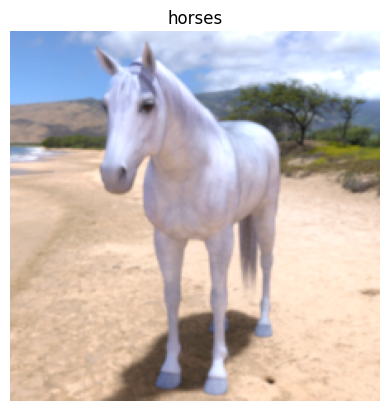

In [17]:
# Access a single sample
image, label = hoh_train[0]
print(f"Single image: shape={image.shape}, dtype={image.dtype}")
print(f"Label: {label} ({hoh_train.classes[label]})")

# Visualize
plt.imshow(image.permute(1, 2, 0))  # CHW -> HWC for matplotlib
plt.title(hoh_train.classes[label])
plt.axis("off");

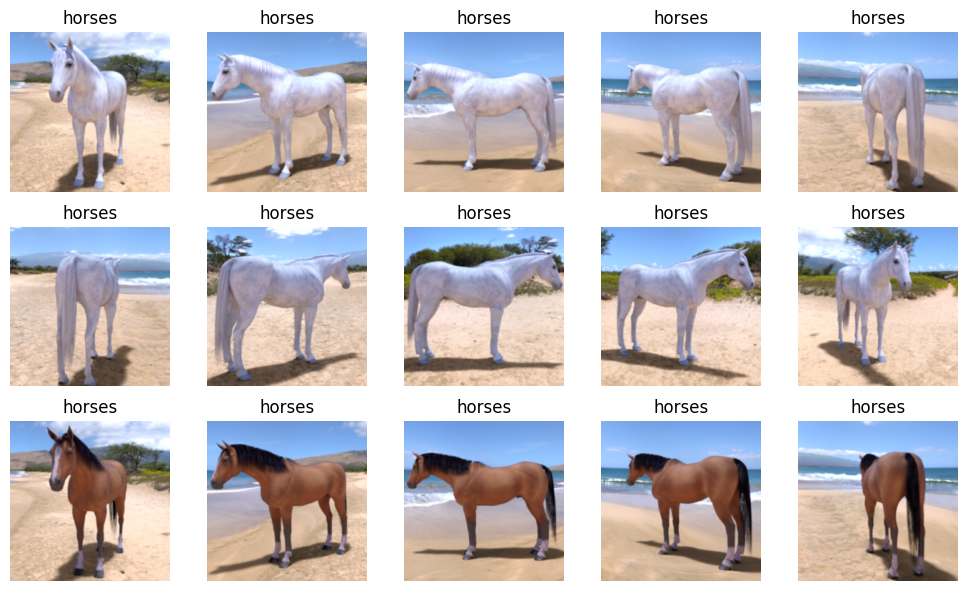

In [18]:
# Display a grid of training samples
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
for i, ax in enumerate(axes.ravel()):
    img, label = hoh_train[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(hoh_train.classes[label])
    ax.axis("off")
plt.tight_layout()

### Batching with DataLoader

To get the benefits of **stochastic gradient descent** (SGD), we feed data in batches. The `DataLoader` handles this automatically:

```python
loader = DataLoader(dataset, batch_size=32, shuffle=True)
for images, labels in loader:
    # images: (32, C, H, W), labels: (32,)
    ...
```

Each iteration yields a batch of tensors, ready for the model.

In [19]:
batch_size = 32

train_dl = DataLoader(hoh_train, batch_size=batch_size, shuffle=True)

# How many batches?
print(f"Dataset size: {len(hoh_train)}")
print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(train_dl)}")
print(f"  (last batch may be smaller: {len(hoh_train) % batch_size} samples)")

# Inspect one batch
batch_images, batch_labels = next(iter(train_dl))
print(f"\nBatch image shape: {batch_images.shape}")
print(f"Batch label shape: {batch_labels.shape}")

Dataset size: 1027
Batch size: 32
Number of batches: 33
  (last batch may be smaller: 3 samples)

Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])


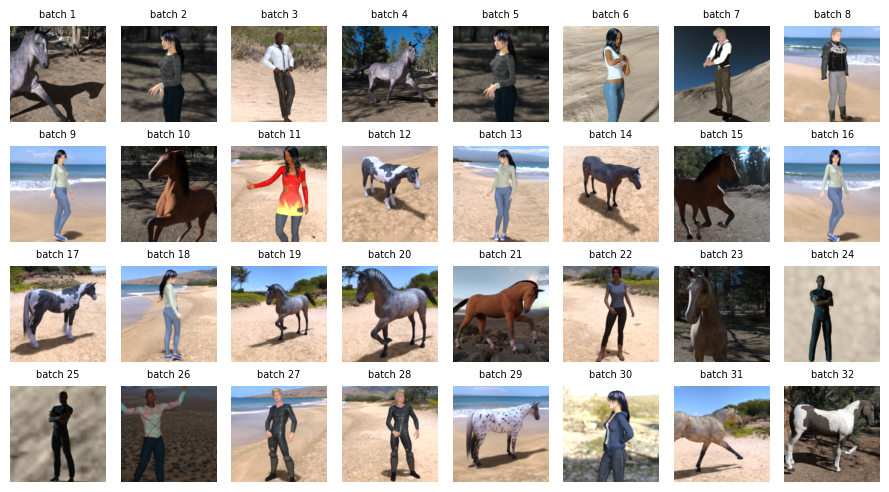

In [20]:
# Display the first image from each batch
fig, axs = plt.subplots(4, 8, figsize=(9, 5))
axs_flat = axs.ravel()
for i, (img_batch, label_batch) in enumerate(train_dl):
    if i >= len(axs_flat):
        break
    axs_flat[i].imshow(img_batch[0].permute(1, 2, 0))
    axs_flat[i].set_title(f"batch {i+1}", fontsize=7)
    axs_flat[i].axis("off")
plt.tight_layout()

### Optimizing Data Loading

`DataLoader` provides several options to speed up training:

- **`shuffle=True`** - Randomly reorders samples each epoch. Essential for training to prevent the model from learning the order of samples.

- **`num_workers=N`** - Uses N subprocesses to load data in parallel. While the GPU processes the current batch, workers prepare the next batches. This overlaps data loading with computation.

- **`pin_memory=True`** - Allocates data in page-locked (pinned) memory, enabling faster CPU→GPU transfer. Use this when training on GPU.

```python
# Optimized DataLoader for GPU training
loader = DataLoader(dataset, batch_size=32, shuffle=True,
                    num_workers=4, pin_memory=True)
```

**Note:** On macOS, `num_workers > 0` can sometimes cause issues. If you encounter problems, set `num_workers=0` (the default).

### Preprocessing with Transforms

In PyTorch, preprocessing is done via `torchvision.transforms.Compose`, which chains transformations applied to each image when it's loaded. Common transforms:

- `transforms.Resize((H, W))` — Resize to target size
- `transforms.ToTensor()` — Convert PIL image to tensor, scale to [0, 1]
- `transforms.Normalize(mean, std)` — Normalize channels


In [21]:
# Preprocessing transform: resize, convert to tensor, and normalize
H = W = 224

preprocess_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Recreate datasets with preprocessing
hoh_train_pp = datasets.ImageFolder("data/horses_or_humans/train", transform=preprocess_transform)
hoh_test_pp = datasets.ImageFolder("data/horses_or_humans/test", transform=preprocess_transform)

# Check a sample
img, label = hoh_train_pp[0]
print(f"Preprocessed image: shape={img.shape}, min={img.min():.2f}, max={img.max():.2f}")

Preprocessed image: shape=torch.Size([3, 224, 224]), min=-1.72, max=2.64


### Data Augmentation

We almost always wish we had *more data*! Data augmentation creates variants of our original images by applying random transformations. A horse is still a horse whether flipped or slightly rotated.

In PyTorch, augmentation transforms are added to `transforms.Compose` and applied on-the-fly during training. Each epoch sees different random variants of the same images.

Common augmentation transforms:
- `transforms.RandomHorizontalFlip()` — flip left/right with 50% probability
- `transforms.RandomRotation(degrees)` — random rotation within ±degrees
- `transforms.ColorJitter(brightness, contrast)` — random color adjustments
- `transforms.RandomResizedCrop(size)` — random crop and resize

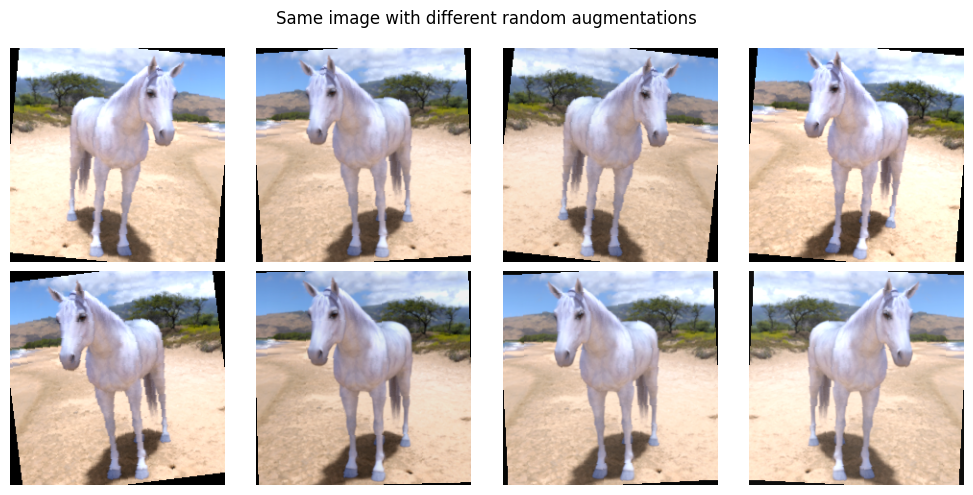

In [22]:
# Define augmentation pipeline for training
augment_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

hoh_train_aug = datasets.ImageFolder("data/horses_or_humans/train", transform=augment_transform)

# Display augmented samples from the same image
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
for ax in axs.ravel():
    img, label = hoh_train_aug[0]  # same index, different augmentation each time
    img_display = inv_normalize(img).clamp(0, 1)
    ax.imshow(img_display.permute(1, 2, 0))
    ax.axis("off")
plt.suptitle("Same image with different random augmentations")
plt.tight_layout()

> **❓ Question 4: Data Pipelines**
>
> 1. What is the difference between preprocessing transforms and augmentation transforms? When should each be applied?
> 2. Why do we apply augmentation only to the training set and not the test set?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. **Preprocessing transforms** are deterministic operations applied to all data (train, val, and test) to get images into the format the model expects — resizing, converting to tensor, normalizing. **Augmentation transforms** are stochastic operations (random flips, rotations, crops) applied only to training data to simulate additional examples. Preprocessing ensures consistent input format; augmentation increases effective training set diversity.
>
> 2. Augmentation is a training-time regularization technique designed to improve generalization. At evaluation time, we want consistent, deterministic predictions — applying random augmentations to test data would add noise to our evaluation metrics and make results non-reproducible. The test set should represent the real-world distribution as faithfully as possible.

</details>

### Creating a Validation Split

The Horses-or-Humans dataset comes with predefined train and test splits, but no validation set. We can create one using `torch.utils.data.random_split()`:

In [23]:
# Split training data: 80% train, 20% validation
generator = torch.Generator().manual_seed(SEED)
train_size = int(0.8 * len(hoh_train_aug))
val_size = len(hoh_train_aug) - train_size

hoh_train_split, hoh_val_split = random_split(hoh_train_aug, [train_size, val_size],
                                               generator=generator)

# Note: the val split inherits the augmentation transform.
# For proper evaluation, we should use non-augmented transforms for validation.
# One approach: create a wrapper that overrides the transform.
hoh_val_proper = datasets.ImageFolder("data/horses_or_humans/train", transform=preprocess_transform)
hoh_val_proper = Subset(hoh_val_proper, hoh_val_split.indices)

print(f"Train split: {len(hoh_train_split)}")
print(f"Val split:   {len(hoh_val_proper)}")
print(f"Test:        {len(hoh_test_pp)}")

Train split: 821
Val split:   206
Test:        256


> **❓ Question 5: Validation Pipeline**
>
> 1. Why do we apply the non-augmented preprocessing transform to the validation set instead of the augmented transform?
> 2. What could go wrong if we accidentally shuffled the test set during evaluation?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. The validation set is used to estimate generalization performance during training. Applying random augmentations would add noise to validation metrics, making it harder to judge whether the model is actually improving. We want validation to simulate real-world inference conditions, where images come in as-is (no random flips or rotations). Augmentation is a training trick, not a testing trick.
>
> 2. Shuffling itself doesn't change the *values* of the metrics (loss and accuracy are computed over all samples), so the aggregate numbers would be the same. However, shuffling affects **reproducibility** — if you're debugging by looking at specific predictions (e.g., "which images are misclassified?"), shuffling makes results non-deterministic across runs. It also adds unnecessary overhead. For evaluation, `shuffle=False` is standard practice.

</details>

In [24]:
# Create DataLoaders for use in Parts 3 & 4
hoh_train_loader = DataLoader(hoh_train_split, batch_size=32, shuffle=True)
hoh_val_loader = DataLoader(hoh_val_proper, batch_size=32, shuffle=False)
hoh_test_loader = DataLoader(hoh_test_pp, batch_size=32, shuffle=False)

batch = next(iter(hoh_train_loader))
print(f"Batch shape: images={batch[0].shape}, labels={batch[1].shape}")

Batch shape: images=torch.Size([32, 3, 224, 224]), labels=torch.Size([32])


## Part 4: Transfer Learning

In Part 2, we saw that CNN features transfer well — even a Random Forest trained on CNN-extracted features outperformed one trained on raw pixels. Transfer learning takes this idea further: instead of training a CNN from scratch on our small dataset, we start from a model already trained on millions of images and adapt it to our task. The data pipeline we built in Part 3 (with preprocessing, augmentation, and DataLoaders) is exactly what we need to feed images into a pretrained model.

Instead of training from scratch, we:

1. **Load a pretrained model** (e.g., MobileNetV2)
2. **Freeze the base layers** — prevent their weights from updating
3. **Replace the classifier head** — add new layers suited to our task
4. **Train only the new head** on our data

This works because early layers learn general features (edges, textures) that transfer across tasks, while later layers learn task-specific features.

### MobileNetV2

[MobileNetV2](https://pytorch.org/vision/stable/models/mobilenetv2.html) is a lightweight architecture designed for mobile and edge devices. It uses depthwise separable convolutions to achieve good accuracy with far fewer parameters than models like ResNet.

In [25]:
# Load pretrained MobileNetV2
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

base_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze all base model parameters
for param in base_model.parameters():
    param.requires_grad = False

# Replace the classifier head
# MobileNetV2 original: classifier = Sequential(Dropout(0.2), Linear(1280, 1000))
# We replace with our binary classification head
base_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
)

base_model = base_model.to(device)

# Only the new classifier parameters are trainable
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in base_model.parameters())
print(f"Trainable params: {trainable_params:,} / {total_params:,} total")

Trainable params: 1,312,769 / 3,536,641 total


In [26]:
# Training function for transfer learning (binary classification)
# Note: This is similar to train_binary() from Part 2, adapted for ImageFolder
# datasets (which return integer labels requiring .float() conversion) and with
# per-epoch printing to monitor transfer learning progress.
def train_transfer(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.BCEWithLogitsLoss()  # raw logits, no sigmoid in model
    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        history["loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} — "
              f"loss: {train_loss:.4f}, acc: {train_acc:.4f} — "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

    return history


optimizer = optim.Adam(base_model.classifier.parameters(), lr=0.0001)

torch.manual_seed(SEED)
history_transfer = train_transfer(base_model, hoh_train_loader, hoh_val_loader,
                                  optimizer, epochs=10)

Epoch 1/10 — loss: 0.3575, acc: 0.9537 — val_loss: 0.1189, val_acc: 1.0000
Epoch 2/10 — loss: 0.0946, acc: 0.9915 — val_loss: 0.0441, val_acc: 1.0000
Epoch 3/10 — loss: 0.0484, acc: 0.9951 — val_loss: 0.0241, val_acc: 1.0000
Epoch 4/10 — loss: 0.0362, acc: 0.9927 — val_loss: 0.0238, val_acc: 0.9951
Epoch 5/10 — loss: 0.0387, acc: 0.9927 — val_loss: 0.0133, val_acc: 0.9951
Epoch 6/10 — loss: 0.0221, acc: 0.9951 — val_loss: 0.0087, val_acc: 1.0000
Epoch 7/10 — loss: 0.0482, acc: 0.9866 — val_loss: 0.0106, val_acc: 1.0000
Epoch 8/10 — loss: 0.0180, acc: 0.9976 — val_loss: 0.0079, val_acc: 1.0000
Epoch 9/10 — loss: 0.0128, acc: 0.9988 — val_loss: 0.0063, val_acc: 1.0000
Epoch 10/10 — loss: 0.0074, acc: 1.0000 — val_loss: 0.0050, val_acc: 1.0000


In [27]:
# Evaluate on test set
criterion = nn.BCEWithLogitsLoss()
base_model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in hoh_test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = base_model(images).squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss/test_total:.4f}")
print(f"Test Accuracy: {test_correct/test_total:.4f}")

Test Loss: 0.1744
Test Accuracy: 0.9570


💬 **Discuss:** We reached ~96% test accuracy in just 10 epochs with only ~800 training images. MobileNetV2 was originally trained on ImageNet - over 1.2 million images across 1,000 classes. What challenges would you face trying to reach similar accuracy on Horses-or-Humans without a pretrained model?

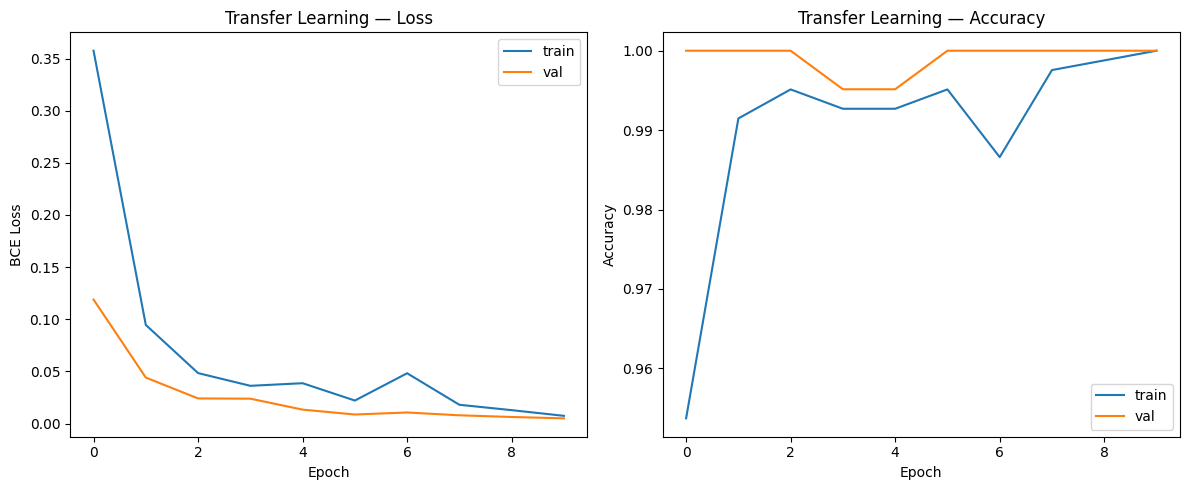

In [28]:
# Plot transfer learning training curves
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(history_transfer["loss"], label="train")
axs[0].plot(history_transfer["val_loss"], label="val")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("BCE Loss")
axs[0].set_title("Transfer Learning — Loss")
axs[0].legend()

axs[1].plot(history_transfer["accuracy"], label="train")
axs[1].plot(history_transfer["val_accuracy"], label="val")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Transfer Learning — Accuracy")
axs[1].legend()

plt.tight_layout()

> **❓ Question 6: Transfer Learning**
>
> 1. Why do we freeze the base model's parameters? What would happen if we didn't?
> 2. The pretrained model was trained on ImageNet (1000 classes, natural images). Why does it work well for horses vs. humans, which is a very different task?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Freezing prevents the pretrained weights from being modified during training. The base model has already learned powerful feature representations from millions of ImageNet images. If we allowed these weights to update with our small dataset (~800 training images), the model would quickly overfit — the gradients from our small dataset would corrupt the general features learned from the much larger dataset. By freezing, we treat the base model as a fixed feature extractor and only train the small classifier head.
>
> 2. Early and middle layers of CNNs learn **hierarchical, general-purpose features**: edges, textures, shapes, parts of objects. These features are useful across many vision tasks, not just the original ImageNet classes. The horses-vs-humans task still involves recognizing shapes (horse body vs. human body) and textures (fur, skin, clothing) in natural images — exactly the kind of features MobileNetV2 learned. We only need to train a small classifier to combine these existing features into a new decision boundary.

</details>